In [1]:
%matplotlib inline

import importlib.util
import math
import os.path
from os import path
import time

from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.callbacks.tracker import *
from fastai.utils.ipython import * 
torch.backends.cudnn.benchmark = True
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import nn

# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
df = pd.read_csv('./labels.csv')

In [3]:
len(df)

255530

In [4]:
df.head(5)

,image_name,tags
0,953619,0 1 5 17 38 36 15 6 5 1
1,953958,10 7 15 26 26 21 10 8 1 2
2,954184,0 0 4 8 41 56 10 3 4 0
3,954113,0 1 4 6 48 37 23 5 2 2
4,953980,0 3 6 15 57 39 6 1 1 1


In [5]:
"""
tfms = ([
    flip_lr(p=0.5),
    brightness(change=(0.4,0.6)),
    contrast(scale=(0.7,1.3))
], [])
"""
tfms = ([], [])

In [6]:
scores_map = dict(zip(df.image_name, df.tags))
labels = list(scores_map.keys())

In [7]:
from PIL import Image
assets_not_on_disk = []
corrupt_images = [440774, 179118, 371434, 277832, 230701, 729377]
for i, img_id in enumerate(labels):
    if (i % 50000 == 0):
        print(i) 
    if not (os.path.exists(os.path.join('./data', str(img_id)+'.jpg'))):
        assets_not_on_disk.append(img_id)
    elif (os.stat(os.path.join('./data', str(img_id)+'.jpg')).st_size/1024 < 50): #img size is < 50KB
       corrupt_images.append(img_id)
    # else:
    #    try:
    #        img=Image.open(os.path.join('./data', str(img_id)+'.jpg'))
    #        img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
    #    except:
    #        print(f"corrupt image:{img_id}")
    #        corrupt_images.append(img_id)
        

0
50000
100000
150000
200000
250000


In [8]:
len(labels), len(assets_not_on_disk), len(corrupt_images)

(255530, 22, 21035)

In [9]:
print(f"Total available images: {len(labels) - len(assets_not_on_disk) - len(corrupt_images)}")

Total available images: 234473


In [10]:
missing_images = assets_not_on_disk + corrupt_images

In [11]:
len(missing_images)

21057

In [12]:
df = df[~df.image_name.isin(missing_images)]

In [13]:
len(df), (len(labels) - len(missing_images))

(234474, 234473)

In [14]:
df.head(5)

,image_name,tags
10,953417,0 0 0 5 32 50 23 10 3 1
11,953777,0 3 2 3 13 40 35 21 8 3
12,953756,0 2 3 9 35 50 20 5 2 2
13,954195,0 1 7 26 56 23 6 1 0 2
14,953903,0 1 4 5 33 50 17 9 3 2


In [15]:
datablocks_data = list(zip(
                        df.image_name.apply(
                            lambda x: '{}.jpg'.format(x)), df.tags
                       ))
datablocks_df = pd.DataFrame(datablocks_data, columns = ['name', 'label'])

In [16]:
datablocks_df.head(5)

,name,label
0,953417.jpg,0 0 0 5 32 50 23 10 3 1
1,953777.jpg,0 3 2 3 13 40 35 21 8 3
2,953756.jpg,0 2 3 9 35 50 20 5 2 2
3,954195.jpg,0 1 7 26 56 23 6 1 0 2
4,953903.jpg,0 1 4 5 33 50 17 9 3 2


In [17]:
# datablocks_df = datablocks_df.head(100000)

In [18]:
# Recompute labels since key is has .jpg extension
scores_map = dict(zip(datablocks_df.name, datablocks_df.label))
labels = list(datablocks_df.name)

In [19]:
len(labels)

234474

In [20]:
class NimaLabelList(CategoryList):
    _processor=None
    def __init__(self, items:Iterator, classes=labels, label_delim:str=None, **kwargs):
        super().__init__(items, classes=classes, **kwargs)

    def get(self, i):
        dist = scores_map[self.items[i]]
        dist = np.array(dist.split(' '), dtype=float)
        dist = dist/dist.sum()
        return dist

In [21]:
func = lambda o: o.split('/')[1]

In [22]:
data = (ImageList.from_df(datablocks_df, path='./data')
        .split_by_rand_pct()
        .label_from_func(func, label_cls=NimaLabelList)
        .transform(tfms, size=224)
        .databunch(bs=64))

In [23]:
data

ImageDataBunch;

Train: LabelList (187580 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: NimaLabelList
[0.       0.       0.       0.040323 0.258065 0.403226 0.185484 0.080645 0.024194 0.008065],[0.       0.015625 0.023438 0.070312 0.273438 0.390625 0.15625  0.039062 0.015625 0.015625],[0.       0.008197 0.057377 0.213115 0.459016 0.188525 0.04918  0.008197 0.       0.016393],[0.       0.008065 0.032258 0.040323 0.266129 0.403226 0.137097 0.072581 0.024194 0.016129],[0.       0.007937 0.015873 0.031746 0.142857 0.325397 0.230159 0.134921 0.079365 0.031746]
Path: data;

Valid: LabelList (46894 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: NimaLabelList
[0.012945 0.029126 0.048544 0.100324 0.148867 0.15534  0.171521 0.148867 0.090615 0.093851],[0.021472 0.06135  0.153374 0.248466 0.282209 0.141104 0.055215 0.021472 0.009202 0.006135],[0.

In [24]:
data.c

234474

In [25]:
data.c = 10

In [26]:
x,y = next(iter(data.train_dl))

In [27]:
len(x), len(y)

(64, 64)

In [28]:
# data.show_batch(rows=5, figsize=(9,7))

In [29]:
# (input, target)
def emd(y_hat, y):
    cdf_y = torch.cumsum(y, dim=-1)
    cdf_y_hat = torch.cumsum(y_hat, dim=-1).double()
    power = torch.pow((cdf_y - cdf_y_hat), 2)
    emd = torch.sqrt(torch.mean(power, dim=-1))
    return torch.mean(emd)

## Transfer Learning using Mobilenet V2

In [30]:
# learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learner = cnn_learner(
    data,
    models.mobilenet_v2,
    pretrained=True,
    loss_func=emd,
    ps=0.75,
    #opt_func=optim.SGD
)

In [31]:
y_hat = learner.model(x)

In [32]:
y_hat.shape, y.shape

(torch.Size([64, 10]), torch.Size([64, 10]))

In [33]:
emd(y_hat, y)

tensor(5.7130, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)

In [34]:
y[0], torch.cumsum(y[0], dim=0)

(tensor([0.0000, 0.0179, 0.0298, 0.1190, 0.4226, 0.3274, 0.0655, 0.0119, 0.0060,
         0.0000], device='cuda:0', dtype=torch.float64),
 tensor([0.0000, 0.0179, 0.0476, 0.1667, 0.5893, 0.9167, 0.9821, 0.9940, 1.0000,
         1.0000], device='cuda:0', dtype=torch.float64))

In [35]:
learner.loss_func

<function __main__.emd(y_hat, y)>

### Freeze Mobilenet Layers and train only the last layer

In [36]:
with gpu_mem_restore_ctx():
    learner.fit_one_cycle(1)
    #learner.fit(2, lr=[3e-7,3e-7, 3e-6]) # discriminative learning rates

epoch,train_loss,valid_loss,time
0,0.119096,0.081332,06:30


In [37]:
learner.save('stage-1')

In [38]:
learner.load('stage-1');

In [39]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


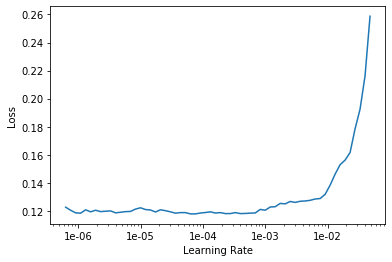

In [40]:
learner.recorder.plot()

### Train entire model

In [42]:
learner.unfreeze()
with gpu_mem_restore_ctx():
    learner.fit_one_cycle(10, 3e-3)
    # learner.fit(5, lr=[3e-7,3e-7, 3e-6]) # discriminative learning rates

epoch,train_loss,valid_loss,time
0,0.086095,0.085508,06:45
1,0.087413,0.091290,06:53
2,0.089224,0.087246,06:58
3,0.089472,0.108424,07:02
4,0.088316,0.087041,06:58
5,0.086829,0.086684,06:55
6,0.085305,0.225778,07:01
7,0.081741,0.082199,06:59
8,0.080727,0.081699,07:05
9,0.080815,0.080772,07:09


In [43]:
learner.save('stage-2')

In [44]:
pred = learner.model(x)

### Compare model distributions to actual distributions

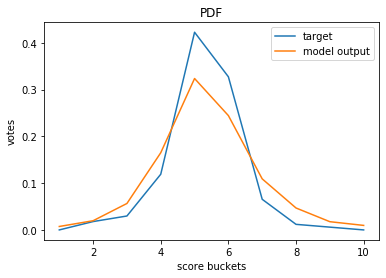

In [45]:
scores = np.arange(1,11)
plt.plot(scores, y[0], label='target');
plt.plot(scores, pred[0], label='model output');
plt.title("PDF")
plt.xlabel("score buckets")
plt.ylabel("votes");
plt.legend();

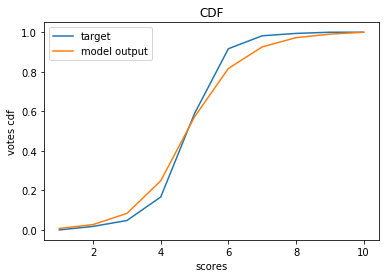

In [46]:
scores = np.arange(1,11)
plt.plot(scores, torch.cumsum(y[0], dim=-1), label='target');
plt.plot(scores, torch.cumsum(pred[0], dim=-1), label='model output');
plt.title("CDF")
plt.xlabel("scores")
plt.ylabel("votes cdf");
plt.legend();